## K-means

* test correctness of NLP vectorization
* test logic of kmeans
* test kmeans on text data

In [1]:
import pyspark as ps
import json

# run it single threaded
sc = ps.SparkContext('local')

In [ ]:
# install the nltk corpus and data
!python -m nltk.downloader all

In [2]:
import os, ipdb

# need to get local path since we are reading local files
cwd = os.getcwd()

In [3]:
test_rdd = sc.textFile('file://' + cwd + '/data/dummy_clusters.csv')

In [4]:
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np

test_rows = test_rdd.map(lambda line: np.array(map(float, line.split(','))))

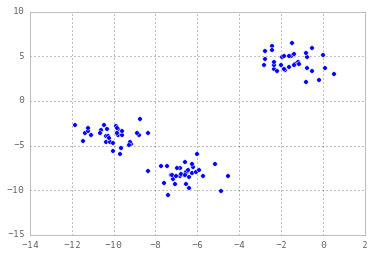

In [6]:
data = np.array(test_rows.collect())
plt.scatter(data[:, 0], data[:,1])

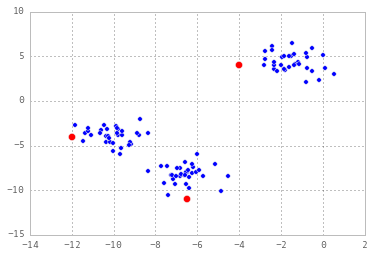

In [7]:
optimal_centroids = [np.array([-12, -4]), np.array([-6.5, -11]), np.array([-4, 4])]
centroids = np.array(optimal_centroids)
plt.scatter(data[:, 0], data[:,1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=50)

In [8]:
# intialize centroids

def Kmeans(features, centers, num_iter):
    error = []
    
    for i in xrange(num_iter):
        def closest_centroid(point, centroids):
            distances = [ np.sqrt(np.sum((point - c)**2)) for c in centroids ]
            return (np.argmin(distances), np.min(distances))
        
        def compute_assignments(point, centroids):
            closest = closest_centroid(point, centroids)
            return (closest[0], (point, 1, closest[1]))
        
        # compute cluster assignments
        assignments = features.map(lambda x: compute_assignments(x, centers))    
            
        # update centroids to mean of assigned points
        means = assignments.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
        centroids = means.map(lambda c: (c[0], c[1][0] / c[1][1])).collect()
        
        for i, p in centroids:
            centers[i] = p
        
        WSSE = means.map(lambda x: x[1][2]).sum()
        error.append(WSSE)
        
        if len(error) > 1 and error[-2] == error[-1]:
            break
            
    return (assignments, centroids, error)

In [9]:
res = Kmeans(test_rows, optimal_centroids, 10)

In [10]:
res

(PythonRDD[21] at RDD at PythonRDD.scala:43,
 [(0, array([-10.04935243,  -3.85954095])),
  (1, array([-6.58196786, -8.17239339])),
  (2, array([-1.4710815 ,  4.33721882]))],
 [261.87984298397168, 108.56785435636178, 108.56785435636178])

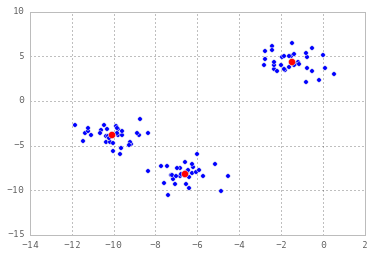

In [11]:
centroids = np.array(map(lambda cent: cent[1], res[1]))

plt.scatter(data[:, 0], data[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=50)

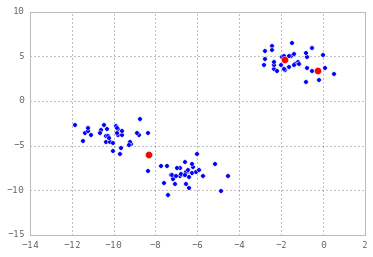

In [12]:
init_centroids = test_rows.takeSample(False, 3)
res = Kmeans(test_rows, init_centroids, 10)

centroids = np.array(map(lambda cent: cent[1], res[1]))

plt.scatter(data[:, 0], data[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=50)

In [13]:
res

(PythonRDD[60] at RDD at PythonRDD.scala:43,
 [(0, array([-8.31566014, -6.01596717])),
  (1, array([-0.23779843,  3.32635307])),
  (2, array([-1.79082156,  4.59929513]))],
 [316.5342334216989,
  224.83141311945371,
  224.53771994362125,
  223.99847880001542,
  223.6189950139244,
  223.6189950139244])

## All Together Now

In [14]:
import nltk, string

def tokenize(text):
    tokens = [] 
    
    for word in nltk.word_tokenize(text):
        if word \
            not in nltk.corpus.stopwords.words('english') \
            and word not in string.punctuation \
            and word != '``':    
                tokens.append(word)
    
    return tokens

In [15]:
sc.stop()

In [16]:
# run on all cores
sc = ps.SparkContext()
sc.master

u'local[*]'

In [17]:
from collections import Counter

In [25]:
# parse input essay file
essay_rdd = sc.textFile('file://' + cwd + '/data/donors_choose/essays.json')
row_rdd = essay_rdd.map(lambda x: json.loads(x))

# tokenize documents
tokenized_rdd = row_rdd.filter(lambda row: row['essay'] and row['essay'] != '') \
                       .map(lambda row: row['essay']) \
                       .map(lambda text: text.replace('\\n', '').replace('\r', '')) \
                       .map(lambda text: tokenize(text))

# compute term and document frequencies
term_frequency = tokenized_rdd.map(lambda terms: Counter(terms))

doc_frequency = term_frequency.flatMap(lambda counts: counts.keys()) \
                             .map(lambda keys: (keys, 1)) \
                             .reduceByKey(lambda a, b: a + b)

In [28]:
num_features = 10000

top_terms = doc_frequency.top(num_features, key=lambda a: a[1])

In [30]:
import math

total_docs = essay_rdd.count()
idf = map(lambda tup: (tup[0], math.log(float(total_docs) / (1 + tup[1]))), top_terms)

In [31]:
broadcast_idf = sc.broadcast(idf)

def vectorize(tokens):
    word_counts = Counter(tokens)
    doc_length = sum(word_counts.values())
    
    vector = [word_counts.get(word[0], 0) * word[1] / float(doc_length) for word in broadcast_idf.value]
    return np.array(vector)

In [32]:
bag_of_words = tokenized_rdd.filter(lambda x: len(x) > 0).map(vectorize)

In [33]:
bag_of_words.persist()

PythonRDD[30] at RDD at PythonRDD.scala:43

In [34]:
top_n = 10
summary = bag_of_words.map(lambda x: map(lambda idx: broadcast_idf.value[idx][0], np.argsort(x)[::-1][:top_n]))

In [35]:
summary.take(15)

[[u'SAT',
  u'preparation',
  u'tutors',
  u'classes',
  u'Unlike',
  u'Regents',
  u'cash',
  u'term',
  u'11th',
  u'districts'],
 [u'doll',
  u'pregnancy',
  u'baby',
  u'Think',
  u'effort',
  u'Over',
  u'simulated',
  u'alter',
  u'prevention',
  u"''"],
 [u'frequently',
  u'rampant',
  u'team',
  u'Walk',
  u'evening',
  u'views',
  u'runs',
  u'entertainment',
  u'Seeing',
  u'NY'],
 [u'SAT',
  u'P',
  u'college',
  u'History',
  u'advisory',
  u'professions',
  u'talks',
  u'counselor',
  u'aside',
  u'II'],
 [u'P',
  u'seniors',
  u'contemporary',
  u'graduating',
  u'graduation',
  u'Bronx',
  u'Richard',
  u'Memory',
  u'Ralph',
  u'gift'],
 [u'weather',
  u'television',
  u'India',
  u'P.S',
  u'player',
  u'reports',
  u'grant',
  u'examples',
  u'funded',
  u'equipment.'],
 [u'Richard',
  u"'ve",
  u'novels',
  u'flame',
  u'God',
  u'Chocolate',
  u'Following',
  u'fan',
  u'Eyes',
  u'copies'],
 [u'geography',
  u'slide',
  u'assigned',
  u'themes',
  u'9th',
  u'theme

## Kmeans on Essays

In [36]:
sample_data = bag_of_words.sample(False, 0.1)

In [37]:
sample_data.persist()

PythonRDD[32] at RDD at PythonRDD.scala:43

In [38]:
# initialize centroids
k = 100

centroids = sample_data.takeSample(False, k)

In [39]:
text_results = Kmeans(sample_data, centroids, 3)
text_results

(PythonRDD[53] at RDD at PythonRDD.scala:43,
 [(0, array([ 0.0005783 ,  0.0032016 ,  0.00302903, ...,  0.        ,
           0.        ,  0.        ])),
  (78, array([ 0.00059769,  0.00379232,  0.00193364, ...,  0.        ,
           0.        ,  0.        ])),
  (39, array([ 0.00056981,  0.00327351,  0.00375755, ...,  0.        ,
           0.        ,  0.        ])),
  (40, array([ 0.00020996,  0.00342656,  0.00253888, ...,  0.        ,
           0.        ,  0.        ])),
  (1, array([ 0.00070413,  0.00337991,  0.00278605, ...,  0.        ,
           0.        ,  0.        ])),
  (79, array([  5.67428587e-04,   3.35750602e-03,   2.55920240e-03, ...,
            4.38654131e-05,   1.09120055e-05,   8.17550213e-06])),
  (80,
   array([ 0.0005359,  0.0087459,  0.       , ...,  0.       ,  0.       ,  0.       ])),
  (41, array([ 0.00063245,  0.00302752,  0.00235   , ...,  0.        ,
           0.        ,  0.        ])),
  (2, array([  6.26325568e-04,   3.02990647e-03,   3.3824050

In [40]:
filtered_res = text_results[0].reduceByKey(lambda x, y:  (x[0] ,x[1] + y[1]))
common = filtered_res.map(lambda tup: (tup[0], tup[1][1])).filter(lambda x: x[1] > 1).collect()
topics = np.array(common)
top_topics = np.argsort(topics[:,1])[::-1][:10]
topics[top_topics]

array([[   79, 13037],
       [   98,  6957],
       [   74,  6635],
       [   27,  5514],
       [   83,  3713],
       [   64,  2545],
       [   71,  2335],
       [    8,  2174],
       [   73,  1945],
       [    9,  1862]])

In [41]:
import pandas as pd

top_n = 20
df = pd.DataFrame(text_results[1])

df.columns = ['a', 'b']
df_index = df.set_index('a')

print "Top Words for each Cluster:\n"

for i , v in df_index.loc[topics[top_topics][:,0]].iterrows():
    print "%d: %s" % (i, ", ".join(top_terms[j][0] for j in v.b.argsort()[::-1][:top_n]))
    print "\n"

Top Words for each Cluster:

79: '', world, math, We, would, work, community, They, Our, see, children, kids, learning, want, year, life, project, class, learn, make


98: technology, iPad, computer, computers, iPads, access, use, laptop, research, apps, learning, classroom, would, math, world, using, '', skills, projects, able


74: books, reading, read, library, book, readers, level, '', love, leveled, home, nonfiction, grade, interest, want, levels, classroom, children, new, non-fiction


27: reading, '', read, book, books, words, readers, children, comprehension, grade, love, skills, Reading, would, fluency, level, materials, want, word, time


83: language, Spanish, English, centers, math, materials, skills, learning, vocabulary, activities, concepts, fun, practice, words, children, '', hands-on, games, learners, learn


64: physical, sensory, special, disabilities, motor, needs, education, play, skills, children, equipment, '', fine, activities, Autism, materials, fitness, health